In [8]:
import tensorflow
print(tensorflow.__version__)

2.8.0


In [9]:
# Install MTCNN library for face detection

!pip install mtcnn


     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [10]:
# Import required packages

import os
import numpy as np
import cv2

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model,model_from_json

In [11]:
# Load Inception-ResNet-v1 model
# Update model and weights path according to the working environment

model_path = "Models/Inception_ResNet_v1.json"
weights_path = "Models/facenet_keras_weights.h5"

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
enc_model = model_from_json(loaded_model_json)


In [12]:
# Loads the Keras model instance.
enc_model.load_weights(weights_path)

In [13]:
# Initialize a MTCNN face detector

mtcnn_detector = MTCNN()

In [14]:
# Given function detects and extracts face from the image

def detect_face(filename, required_size=(160, 160),normalize = True):

    img = Image.open(filename)

    # convert to RGB
    img = img.convert('RGB')
 
    # convert to array
    pixels = np.asarray(img)
 
    # detect faces in the image
    results = mtcnn_detector.detect_faces(pixels)
 
    # bounding box from the first face stored in x1,y1,width,height
    x1, y1, width, height = results[0]['box']

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    # extract the face in the region found above
    face = pixels[y1:y2, x1:x2]
  
    # creates an image memory
    image = Image.fromarray(face)
    # resize pixels to the required size
    image = image.resize(required_size)
    face_array = asarray(image)
 
    if normalize == True:

        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        return (face_array - mean) / std

    else : 
        return face_array

In [15]:
# For all known persons present in the database compute face encodings and load their names/Ids
# known_faces_path is the location of the known images directory/database

known_faces_encodings = []
known_faces_ids = []

known_faces_path = "Images/"

for filename in os.listdir(known_faces_path):
  
  # Detect faces
  face = detect_face(known_faces_path+filename,normalize = True)

  # Compute face encodings

  feature_vector = enc_model.predict(face.reshape(1,160,160,3))
  feature_vector/= np.sqrt(np.sum(feature_vector**2))
  known_faces_encodings.append(feature_vector)

  # Save Person IDs
  label = filename.split('.')[0]
  known_faces_ids.append(label)


known_faces_encodings = np.array(known_faces_encodings).reshape(len(known_faces_encodings),128)
known_faces_ids = np.array(known_faces_ids)

In [16]:
# No. of known Ids loaded from the database

print(known_faces_ids.shape[0])

8


In [17]:
# Function to recognize and give matching score if it is present in face database or return UNKNOWN and 0 score if not present
# threshold generated to find if the lowest matching score is greater than threshold then UNKNOWN will be returned else the closest matching face will be returned 

def recognize(img,known_faces_encodings,known_faces_ids,threshold = 0.75):

  scores = np.zeros((len(known_faces_ids),1),dtype=float)

  enc = enc_model.predict(img.reshape(1,160,160,3))
  enc/= np.sqrt(np.sum(enc**2))

  scores = np.sqrt(np.sum((enc-known_faces_encodings)**2,axis=1))

  match = np.argmin(scores)

  if scores[match] > threshold :

    return ("UNKNOWN",0)
      
  else :

    return (known_faces_ids[match],scores[match])

In [18]:
ls

aa.jpg                 ig.jpg    LFW_dataset/  test2.jpg
ds.jpg                 Images/   Models/       testing.jpg
enc_trainer_model.png  jsr.jpeg  nm.jpg        test_it.jpg
Face_Comparison.ipynb  KHL.jpg   rnc.jpeg      Training.ipynb


In [19]:
# location of image to be identidfied if it is present in the database or not
IMG= "aa.jpg"

In [20]:
from matplotlib import pyplot as plt


In [21]:
# Function to recognize and then plot and print the identified person
def face_recognition(file_path,known_faces_encodings,known_faces_ids,threshold = 0.75):

  img = cv2.imread(file_path)

  results = mtcnn_detector.detect_faces(img)
      

  faces = []
    
  person = "unknown"  
  for i in range(len(results)):
      x,y,w,h = results[i]['box']
      x, y = abs(x), abs(y)
      faces.append([x,y,w,h])

  # Draw the rectangle around each face
  for (x, y, w, h) in faces:   
    image = Image.fromarray(img[y:y+h, x:x+w])
    image = image.resize((160,160))
    face_array = asarray(image)
    # Normalize
    mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
    std = np.std(face_array, axis=(0,1,2), keepdims=True)
    std_adj = np.maximum(std, 1.0)
    face_array_normalized = (face_array - mean) / std
    # Recognize
    label = recognize(face_array_normalized,known_faces_encodings,known_faces_ids,threshold = 0.75)
    person= label[0]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 2)
    cv2.putText(img, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

  # Display
  plt.imshow(img)
  print("The person is ", person )
  

The person is  MS Dhoni


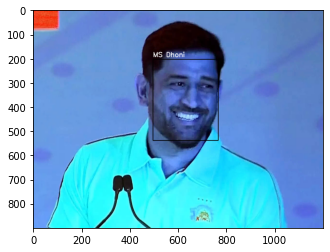

In [22]:
face_recognition(IMG,known_faces_encodings,known_faces_ids,0.75)